## Cutting RFI by finding which signals are detected at exactly the same frequency multiple times

### Setup

In [2]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_array
from scipy.sparse import lil_array
from scipy.sparse import save_npz
from scipy.sparse import load_npz
import os
import glob

In [3]:
# Read in the data

# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()

# Get paths to data
if hostname == "blpc1" or hostname == "blpc2":
    full_dataset_path = "/datax/scratch/nstieg/25GHz_higher.pkl"
    coherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_coherent.pkl"
    incoherent_dataset_path = "/datax/scratch/nstieg/25GHz_higher_incoherent.pkl"
else:
    raise Exception("Data path not known")

# Read in data
# coherent = pd.read_pickle(coherent_dataset_path)
# incoherent = pd.read_pickle(incoherent_dataset_path)
df = pd.read_pickle(full_dataset_path)

In [6]:
# Load in distance and mask
path = "/home/nstieg/BL-COSMIC-2024-proj/frequency_adjacency/adjacent_in_all/"
distances_path = path + "all_within_1000hz.distances.npz"
mask_path = path + "all_within_1000hz.mask.npz"
distances = load_npz(distances_path)
mask = load_npz(mask_path)
print(distances.shape)
print(mask.shape)

(31208910, 31208910)
(31208910, 31208910)


### Figure out what to cut

In [9]:
num_adjacent = mask.sum()
print(f"There are {num_adjacent} adjacencies in the file")

There are 1862417574 adjacencies in the file


In [16]:
# Look at about how many are within certain frequencies
num_collisions = (distances[mask] == 0).sum()
within_hz = {0: num_collisions}
frequencies_to_sample = np.linspace(1, 100, 3)
for frequency in frequencies_to_sample:
    within_hz[frequency] = (distances[mask] <= frequency * 1e-6).sum()

In [17]:
frequencies_to_sample

array([  1. ,  50.5, 100. ])

In [21]:

print(f"There are {num_collisions} collisions in the file with a distance of 0Hz, {round(num_collisions / num_adjacent * 100, 3)}%")
print(f"There are {within_hz[100]} collisions in the file with a distance of 100Hz, {round(within_hz[100] / num_adjacent * 100, 3)}%")

There are 740291930 collisions in the file with a distance of 0Hz, 39.749%
There are 1668028931 collisions in the file with a distance of 100Hz, 89.563%


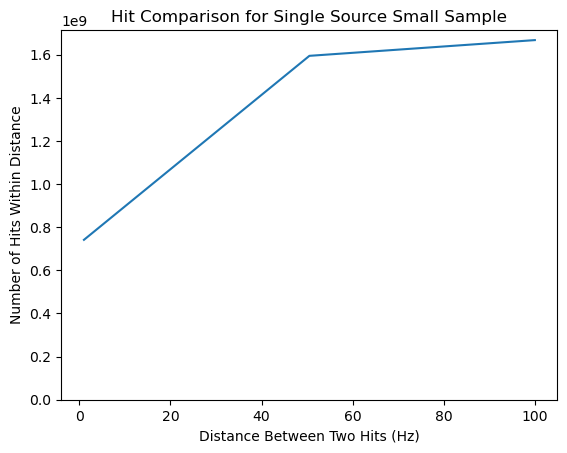

In [22]:

xaxis = frequencies_to_sample
yaxis = [within_hz[frequency] for frequency in frequencies_to_sample]

plt.plot(xaxis, yaxis)
plt.xlabel("Distance Between Two Hits (Hz)")
plt.ylabel("Number of Hits Within Distance")
plt.title("Hit Comparison for Single Source Small Sample")
plt.ylim(bottom=0)
plt.show()

In [23]:
# Let's look at how many collisions there were within a threshold
# Want to do (distances <= threshold) & mask to get all the values which are under the threshold
# including zeroes which are let in by the mask
# However, if we turn all the 0s in the sparse array to Trues, it's not sparse anymore (so it's super slow)
# So how do we maintain the sparsity?
# Well, we can look for the opposite first, the values which are outside the threshold
# Then we can remove those from the mask so there's a new mask just contains the values we care about below the threshold 
# Then the number of collisions within that threshold is the number of Trues in the new mask
# And if we want to get those distances (or the hits which are close to each other), then we can do distances[new_mask] (or new_mask.nonzero())
def find_collisions_at_threshold(threshold):
    # Get those outside threshold
    outside_threshold = distances > threshold

    # Remove those outside threshold from the mask
    # We want to do mask & (~outside_threshold), but note that ~outside_threshold produces an array which is mostly true
    # So instead we'll have to do mask - outside_threshold 
    # (which does xor, so it will have values which are in mask but not outside_threshold, and those in outside_threshold but not mask)
    # Finally, to get rid of values in outside_threshold but not mask, we'll and by mask
    new_mask = mask.multiply(mask - outside_threshold)

    return new_mask

In [24]:
## Confirm the result with how many distances are zero
# Set threshold
threshold_hz = 0
threshold = threshold_hz * 1e-6
new_mask = find_collisions_at_threshold(threshold)
print(new_mask.sum())

740291930


In [25]:
# See how many hits did vs. didn't have another hit within 1000hz
num_hits_with_associated_hit = len(np.unique(np.concatenate(mask.nonzero())))

NameError: name 'first_source' is not defined

In [26]:
print(f"{num_hits_with_associated_hit} hits had another hit within {1000}Hz out of {len(df)} hits ({num_hits_with_associated_hit / len(df) * 100}%)")

30281022 hits had another hit within 1000Hz out of 31208910 hits (97.02684906329635%)


In [27]:
# See how many hits did vs. didn't have another hit at exactly the same frequency
same_frequency = find_collisions_at_threshold(0)
num_same_frequency = len(np.unique(np.concatenate(same_frequency.nonzero())))
print(f"{num_same_frequency} hits had another hit within {0}Hz out of {len(df)} hits ({num_same_frequency / len(df) * 100}%)")

12854493 hits had another hit within 0Hz out of 31208910 hits (41.18853558166562%)
